In [1]:
import pickle
import utils
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(25, 16)}, font_scale=2)
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2

# Functions

In [45]:
def graph_stats_with_gt(df, gt_df, mode='local'):
    '''
    Returns an updated `df` that contains the `is_homograph` column for each linkable cell value in the ground truth.
    If a cell value in `df` does not have a corresponding ground-truth set it to np.nan

    `mode` can be either `local` or 'global` to accordingly choose the ground truth 
    '''
    if mode=='local':
        gt_column='is_local_homograph'
    elif mode=='global':
        gt_column='is_homograph'
    
    is_homograph_gt_dict={}
    for idx, row in tqdm(gt_df.iterrows(), total=len(gt_df)):
        is_homograph_gt_dict[row['cell_text']]=row[gt_column]

    is_homograph_list=[]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row['node_type']=='attr':
            is_homograph_list.append(np.nan)
        else:
            if row['node'] in is_homograph_gt_dict:
                is_homograph_list.append(is_homograph_gt_dict[row['node']])
            else:
                is_homograph_list.append(np.nan)

    df['is_homograph']=is_homograph_list
    return df

# Selected Tables (Wikitables 2013)

In [46]:
# Construct the `graph_stats_with_groundtruth_df`
graph_stats=pd.read_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_df.pickle')

# The ground truth homographs are from the local context (i.e., based on only the values that appear in the selected tables) 
is_homograph_gt_df=pd.read_csv('../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/is_homograph_gt_unique_cell_vals.csv')

In [47]:
graph_stats_with_gt=graph_stats_with_gt(df=graph_stats, gt_df=is_homograph_gt_df, mode='local')
graph_stats_with_gt.to_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_with_groundtruth_df.pickle')

100%|██████████| 632192/632192 [00:41<00:00, 15354.00it/s]


## Evaluation

In [50]:
df_path='output/wikitables_datasets/wikipages_2013/selected_csv_tables/'
graph_stats_with_gt = pd.read_pickle(df_path+'graph_stats_with_groundtruth_df.pickle')
with open('../graph_construction/combined_graphs_output/wikitable_datasets/wikipages_2013/selected_csv_tables/bipartite/bipartite.graph', 'rb') as f:
    G=pickle.load(f)
print("Graph has", G.number_of_nodes(), " nodes and", G.number_of_edges(), "edges")
nodes_with_degree_greater_than_1 = [n for n in graph_stats_with_gt['node'].values if G.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'nodes with degree greater than 1')

# Consider only cell nodes with greater than 1 degree
graph_stats_with_gt = graph_stats_with_gt.loc[graph_stats_with_gt['node'].isin(nodes_with_degree_greater_than_1)]

# Consider only nodes for which the ground truth is known and sort by BC
graph_stats_with_gt=graph_stats_with_gt[(graph_stats_with_gt['is_homograph']==True) | (graph_stats_with_gt['is_homograph']==False)].sort_values(by='approximate_betweenness_centrality', ascending=False)
num_true_homographs=len(graph_stats_with_gt[graph_stats_with_gt['is_homograph']==True])
print("There are", num_true_homographs, 'unique homograph values in the ground truth')

Graph has 632192  nodes and 1152408 edges
There are 154711 nodes with degree greater than 1
There are 9991 unique homograph values in the ground truth


Max Precision: 0.9411764705882353 @k= 101
Max F1-Score: 0.43144893899204245 @k= 14136
The are 9991 homographs based on the ground truth.
At k = 9991 the metrics are:
Precision: 0.419777800020018
Recall: 0.419777800020018
F1-Score: 0.419777800020018


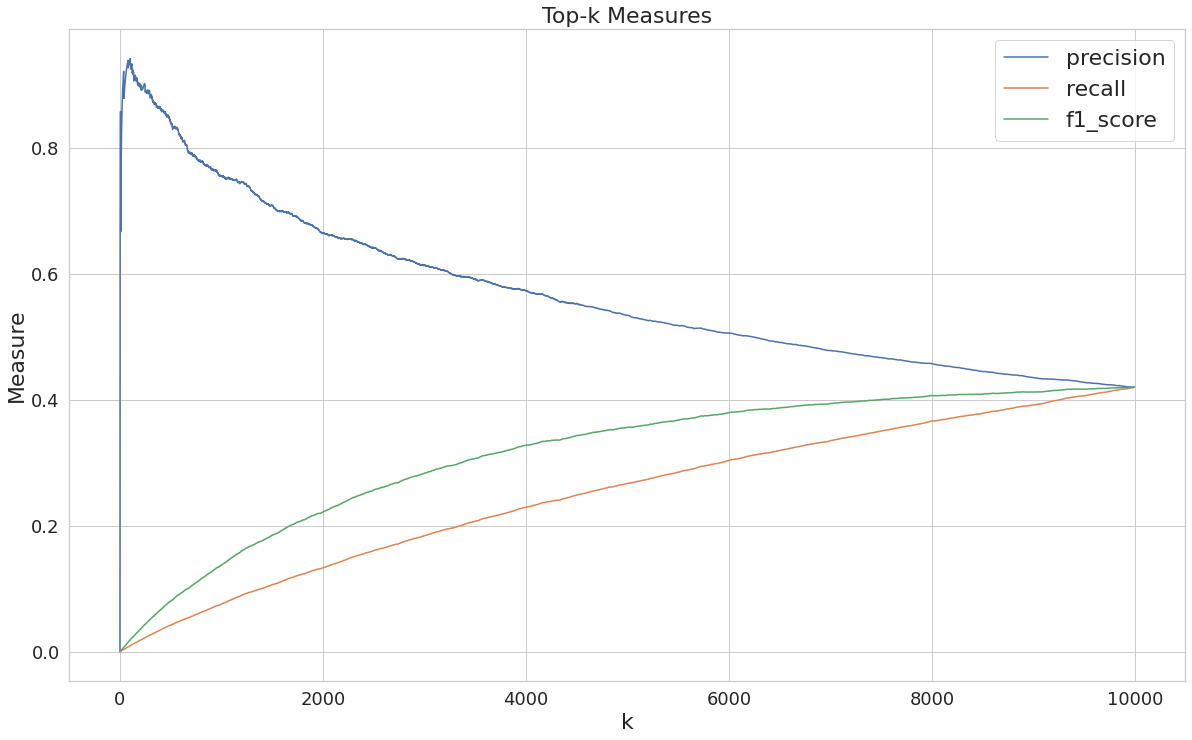

In [51]:
graph_stats_with_gt = utils.calculate_measures(df=graph_stats_with_gt, num_true_homographs=num_true_homographs)
graph_stats_with_gt=graph_stats_with_gt.reset_index(drop=True)
print("Max Precision:", graph_stats_with_gt['precision'].max(), '@k=', graph_stats_with_gt['precision'].idxmax())
print("Max F1-Score:", graph_stats_with_gt['f1_score'].max(), '@k=', graph_stats_with_gt['f1_score'].idxmax())
utils.topk_evaluation.top_k_graphs(graph_stats_with_gt, output_dir='figures/wikitables_datasets/wikipages_2013/selected_csv_tables/')

### Examples

In [68]:
graph_stats_with_gt[graph_stats_with_gt['is_homograph']==False].head(25)

,node,node_type,approximate_betweenness_centrality,is_homograph,precision,recall,f1_score
0,—,cell,0.015888,False,0.000000,0.000000,0.000000
7,World War II,cell,0.003392,False,0.750000,0.000601,0.001200
8,Bye,cell,0.003328,False,0.666667,0.000601,0.001200
38,North America,cell,0.001470,False,0.897436,0.003503,0.006979
40,Incumbent,cell,0.001416,False,0.878049,0.003603,0.007177
81,Retirement,cell,0.000841,False,0.926829,0.007607,0.015090
102,IFL,cell,0.000720,False,0.932039,0.009609,0.019021
105,Dragon,cell,0.000701,False,0.924528,0.009809,0.019412
119,UFC 37,cell,0.000593,False,0.925000,0.011110,0.021956
121,x,cell,0.000587,False,0.918033,0.011210,0.022150


# Full Dataset (Wikitables 2013)

In [8]:
with open('../graph_construction/combined_graphs_output/wikitable_datasets/wikipages_2013/csv_tables/bipartite/bipartite.graph', 'rb') as f:
    G=pickle.load(f)
print("#Nodes:", G.number_of_nodes(), " #Edges:", G.number_of_edges())

#Nodes: 8577470  #Edges: 27547909


# Testing

In [70]:
is_homograph_gt_df=pd.read_csv('../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/is_homograph_gt_cell_instances.csv')

In [103]:
val='Retirement'
is_homograph_gt_df[is_homograph_gt_df['cell_text']==val]

,table_id,pg_title,cell_text,gt_link,gt_wikidata_id,pred_wikidata_id,is_homograph,row_id,col_id,correct_pred,is_local_homograph
470443,0320-447,2008–09 AEK Athens F.C. season,Retirement,http://www.wikipedia.org/wiki/Retirement,Q946865,Q19096892,False,0,6,False,False


In [104]:
print("Column Names:\n", utils.graph_helpers.get_cell_node_column_names(G, val))

table_ids = [val[6:14] for val in utils.graph_helpers.get_cell_node_file_names(G, val)]
print(len(table_ids))
print('page titles:\n', list(is_homograph_gt_df[is_homograph_gt_df['table_id'].isin(table_ids)]['pg_title'].unique()))
# utils.graph_helpers.get_cell_node_neighbors(G, '-')

Column Names:
 ['Time', 'Club', 'Activity - Location', 'Reason', 'Time/Retired', 'Moving to', 'Details', 'Transferred To']
55
page titles:
 ['1998 Catalan motorcycle Grand Prix', '1994 French motorcycle Grand Prix', '2012 Japanese motorcycle Grand Prix', '2012 British motorcycle Grand Prix', '2010 Silverstone Superbike World Championship round', '2005 Turkish motorcycle Grand Prix', '1997 Indonesian motorcycle Grand Prix', 'List of senators in the 38th Parliament of Canada', '2011 Silverstone Superbike World Championship round', 'Isaac Schlossbach', '1999 Malaysian motorcycle Grand Prix', '2011 Spanish motorcycle Grand Prix', '2008 Phillip Island Superbike World Championship round', '2004 Australian motorcycle Grand Prix', '2011 Italian motorcycle Grand Prix', '2008 French motorcycle Grand Prix', '1996 German motorcycle Grand Prix', '2005 Formula BMW World Final', '2011 Woodlands Wellington Season', '2006 Dutch TT', '1991 Malaysian motorcycle Grand Prix', '2010 Indianapolis motorcycle 